<a href="https://colab.research.google.com/github/dellaanima/NLP_GoingDeeper/blob/main/03/Project_ReutersNews_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reuters News Classification

**Table of Contents**

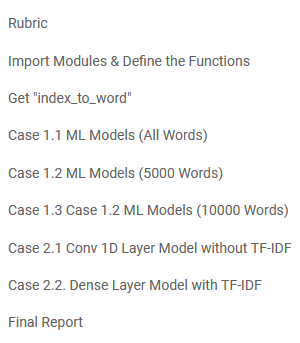

## Rubric

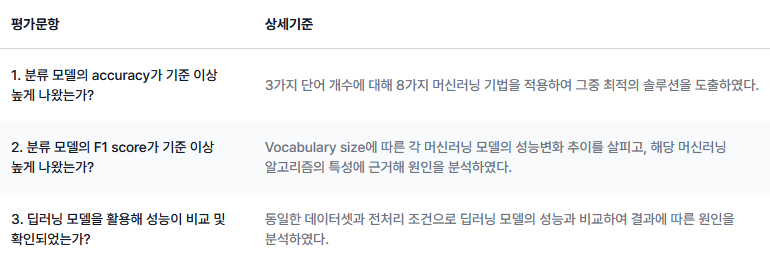

About Reuters News Data
 - 로이터 뉴스 데이터셋은 '뉴스 본문'과 '본문에 해당하는 카테고리에 대한 값(총 46개의 클래스)'이 한 쌍으로 학습 데이터 8,982개, 테스트 데이터 2,246개로 이루어져 있다.
 - 데이터셋의 클래스 별 데이터 분포가 불균형 하다는 것과 데이터셋이 이미 정수로 인코딩 되어 있다는 특징이 있다.

## Import Modules & Define the Functions

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K  # For Keras F1-score

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
def show_data_distribution(x_train, y_train):
    print('Train Samples No. : {}'.format(len(x_train)))
    print('Train Samples No.: {}'.format(len(x_test)))

    print('Train Samples Maximum length :{}'.format(max(len(l) for l in x_train)))
    print('Train Samples Average length :{}'.format(sum(map(len,x_train))/len(x_train)))

    plt.hist([len(s) for s in x_train], bins=50)
    plt.xlabel('length of samples')
    plt.ylabel('number of samples')
    plt.show()

    fig, axe = plt.subplots(ncols=1)
    fig.set_size_inches(11,5)
    sns.countplot(x=y_train)
    plt.show()

In [3]:
def decode_indexes_to_text(indexes, index_to_word):
    decoded = []
    for i in range(len(indexes)):
        t = ' '.join([index_to_word[index] for index in indexes[i]])
        decoded.append(t)
    return decoded


In [4]:
def preprocess_text_with_tfidf(x_train, x_test):
    # DTM 생성
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train)
    print("DTM shape:", x_train_dtm.shape)

    # TF-IDF Matrix 생성
    tfidf_transformer = TfidfTransformer()
    tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
    print("TF-IDF Matrix shape:", tfidfv.shape)

    # 테스트 데이터 변환
    x_test_dtm = dtmvector.transform(x_test)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)

    return tfidfv, tfidfv_test

In [55]:
def evaluate_models(tfidfv, y_train, tfidfv_test, y_test):
    result_acc_list = []
    result_f1_list = []

    def evaluate_and_append(model, name):
        model.fit(tfidfv, y_train)
        predicted = model.predict(tfidfv_test)
        accuracy = accuracy_score(y_test, predicted)
        f1 = f1_score(y_test, predicted, average='weighted')
        result_acc_list.append(accuracy)
        result_f1_list.append(f1)
        print(f"\n{name}: Accuracy : {accuracy:.4f}, F1 Score : {f1:.4f}")

    models = [
        (MultinomialNB(), "Naive Bayes Classifier"),
        (ComplementNB(), "Complement Naive Bayes Classifier") ,
        (LogisticRegression(C=1.0, max_iter=1000, penalty='l2'), "Logistic Regression"),
        (LinearSVC(C=1.0, max_iter=1000, penalty='l2', dual=False), "Linear SVC"),
        (DecisionTreeClassifier(max_depth=10, random_state=0), "Decision Tree"),
        (RandomForestClassifier(n_estimators=5, random_state=0), "Random Forest"),
        (KNeighborsClassifier(n_neighbors=3), "K-Nearest Neighbors"),
        (VotingClassifier(estimators=[
            ('lr', LogisticRegression(C=1.0, max_iter=1000, penalty='l2')),
            ('c', ComplementNB()) ,
        ], voting='soft', n_jobs=-1), "Voting Classifier")
    ]

    for model, name in tqdm(models, desc="in progress"):
        evaluate_and_append(model, name)
        print(f"{name}  model is done training")

    return result_acc_list, result_f1_list


In [76]:
def visualize_model_scores(classifier_list, accuracy_list, f1_list, title):
    data = {
        'Model': classifier_list,
        'Accuracy': accuracy_list,
        'F1 Score(weighted)': f1_list
    }

    df = pd.DataFrame(data)

    print(title)
    print(df.to_string(index=False))

    # 막대 그래프로 시각화
    bar_width = 0.4  # 막대 그래프 너비 설정
    model_positions = range(len(df))  # 모델 위치를 나타내는 숫자 리스트

    plt.figure(figsize=(10, 6))

    # Accuracy 막대 그래프 그리기
    plt.barh(model_positions, df['Accuracy'], color='b', label='Accuracy', height=bar_width)

    # F1 Score 막대 그래프 그리기 (오른쪽으로 이동하여 겹치지 않도록)
    plt.barh([pos + bar_width for pos in model_positions], df['F1 Score(weighted)'], color='r', label='F1 Score(weighted)', alpha=0.7, height=bar_width)

    plt.xlabel("Score")
    plt.ylabel("Model")
    plt.title(title)
    plt.xlim(0, 1.2)  # x축 범위 설정 (0부터 1까지)
    plt.legend(loc='lower right')
    plt.yticks([pos + bar_width / 2 for pos in model_positions], df['Model'])  # y축 눈금 라벨 설정
    plt.tight_layout()  # 그래프 간격 조정
    plt.show()


In [57]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [58]:
def model_dense(input_dim):
    model_dense = tf.keras.Sequential()
    model_dense.add(tf.keras.layers.Input(shape=(input_dim,)))
    model_dense.add(tf.keras.layers.Dense(256, activation='relu'))
    model_dense.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model_dense


In [59]:
def model_conv1d(vocab_size):
    word_vector_dim = 128

    model_conv1d = tf.keras.Sequential()
    model_conv1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model_conv1d.add(tf.keras.layers.Conv1D(256, 32, activation='relu'))
    model_conv1d.add(tf.keras.layers.MaxPooling1D(4))
    model_conv1d.add(tf.keras.layers.Dropout(0.3))
    model_conv1d.add(tf.keras.layers.Dense(46, activation='softmax'))

    return model_conv1d

In [60]:
def visualize_model_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_m'], label='Train F1 Score')
    plt.plot(history.history['val_f1_m'], label='Validation F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 최종 결과 출력
    final_epoch = len(history.history['loss'])
    final_results = {
        'Train Loss': history.history['loss'][-1],
        'Validation Loss': history.history['val_loss'][-1],
        'Train Accuracy': history.history['accuracy'][-1],
        'Validation Accuracy': history.history['val_accuracy'][-1],
        'Train F1 Score': history.history['f1_m'][-1],
        'Validation F1 Score': history.history['val_f1_m'][-1]
    }

    final_results_df = pd.DataFrame(final_results, index=[f'Epoch {final_epoch}'])
    display(final_results_df)


In [61]:
def find_best_classifier(classifier_list, accuracy_list, f1_list):
    best_accuracy = max(accuracy_list)
    best_f1 = max(f1_list)

    best_classifier_acc = classifier_list[accuracy_list.index(best_accuracy)]
    best_classifier_f1 = classifier_list[f1_list.index(best_f1)]

    if best_classifier_acc == best_classifier_f1:
        return f"{best_classifier_acc} (Acc: {best_accuracy:.4f}, F1: {best_f1:.4f})"
    else:
        return f"Best by Accuracy: {best_classifier_acc} (Acc: {best_accuracy:.4f})\nBest by F1 Score: {best_classifier_f1} (F1: {best_f1:.4f})"

In [62]:
# ML Model classifier list
classifier_list = ["MultinomialNB", "ComplementNB", "Logistic Regression", "LinearSVC", "Decision Tree", "Random Forest", "KNeighborsClassifier",  "Voting"]

## Get "index_to_word"

이 데이터의 단어들은 등장 빈도수가 높은 순서대로 낮은 정수가 맵핑되어 있습니다.  num_words=10000은 1~10,000번째로 빈도 순위가 높은 단어만 사용한다는 의미입니다.
단, 10,000을 기재한다고 해서 10,000보다 높은 정수가 맵핑된 단어들이 받아온 데이터에서 사라지는 게 아닙니다. num_words로 주어진 값보다 큰 번호를 가졌던 단어들은 특정 번호로 전부 맵핑이 됩니다.

In [14]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
data = {'Word': list(word_index.keys()), 'Index': list(word_index.values())}
df = pd.DataFrame(data)
df

550378/550378 [==============================] - 0s 0us/step


,Word,Index
0,mdbl,10996
1,fawc,16260
2,degussa,12089
3,woods,8803
4,hanging,13796
...,...,...
30974,rotting,16258
30975,pods,10995
30976,emery,2849
30977,northerly,30979


In [15]:
# 인덱스 +3
index_to_word = {index + 3 : word for word, index in word_index.items()}
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

## Case 1.1 ML Models (All Words)

In [16]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2110848/2110848 [==============================] - 0s 0us/step


Train Samples No. : 8982
Train Samples No.: 2246
Train Samples Maximum length :2376
Train Samples Average length :145.5398574927633


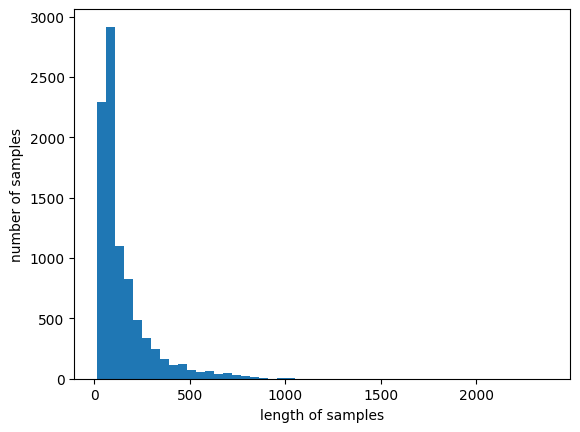

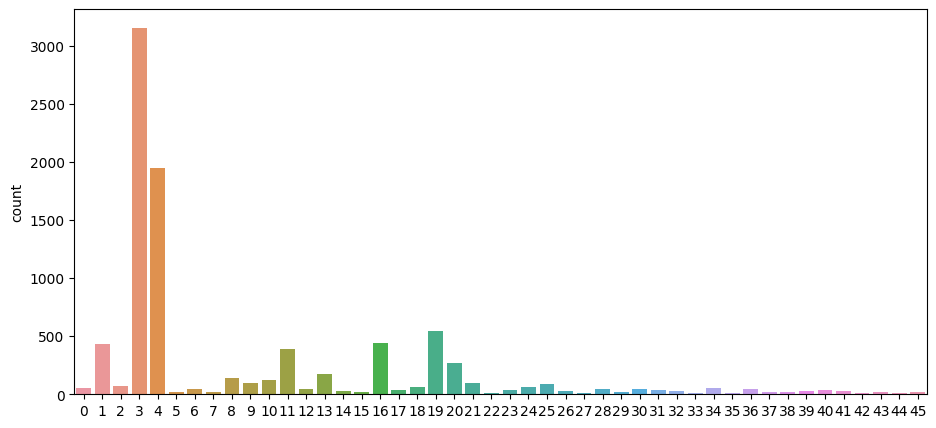

In [17]:
# 데이터 분포 확인
show_data_distribution(x_train, y_train)

In [18]:
x_train = decode_indexes_to_text(x_train, index_to_word)
x_test = decode_indexes_to_text(x_test, index_to_word)

In [51]:
# TF-IDF 전처리
tfidfv_train, tfidfv_test = preprocess_text_with_tfidf(x_train, x_test)

DTM shape: (8982, 9670)
TF-IDF Matrix shape: (8982, 9670)


In [63]:
result_01_acc, result_01_f1 = evaluate_models(tfidfv_train, y_train, tfidfv_test, y_test)
print("Total Report")
print("Accuracies:", result_01_acc)
print("F1 Scores:", result_01_f1)

in progress:  25%|██▌       | 2/8 [00:00<00:00, 16.24it/s]


Naive Bayes Classifier: Accuracy : 0.6567, F1 Score : 0.5764
Naive Bayes Classifier  model is done training

Complement Naive Bayes Classifier: Accuracy : 0.7707, F1 Score : 0.7457
Complement Naive Bayes Classifier  model is done training


in progress:  38%|███▊      | 3/8 [00:27<00:57, 11.46s/it]


Logistic Regression: Accuracy : 0.7952, F1 Score : 0.7728
Logistic Regression  model is done training


in progress:  50%|█████     | 4/8 [00:31<00:34,  8.51s/it]


Linear SVC: Accuracy : 0.8299, F1 Score : 0.8237
Linear SVC  model is done training


in progress:  62%|██████▎   | 5/8 [00:32<00:18,  6.15s/it]


Decision Tree: Accuracy : 0.6202, F1 Score : 0.5776
Decision Tree  model is done training


in progress:  75%|███████▌  | 6/8 [00:34<00:09,  4.81s/it]


Random Forest: Accuracy : 0.6741, F1 Score : 0.6429
Random Forest  model is done training


in progress:  88%|████████▊ | 7/8 [02:44<00:44, 44.93s/it]


K-Nearest Neighbors: Accuracy : 0.7689, F1 Score : 0.7603
K-Nearest Neighbors  model is done training


in progress: 100%|██████████| 8/8 [03:03<00:00, 22.95s/it]


Voting Classifier: Accuracy : 0.7979, F1 Score : 0.7761
Voting Classifier  model is done training
Total Report
Accuracies: [0.6567230632235085, 0.7707034728406055, 0.7951914514692787, 0.8299198575244879, 0.6202137132680321, 0.674087266251113, 0.7689225289403384, 0.7978628673196795]
F1 Scores: [0.5764467518778252, 0.7456682614453047, 0.7727935299669956, 0.8236882254849623, 0.5776398779280149, 0.6429484177284822, 0.7602976247876144, 0.7760922070821794]


## Case 1.2  ML Models (5000 Words)

In [64]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

Train Samples No. : 8982
Train Samples No.: 2246
Train Samples Maximum length :2376
Train Samples Average length :145.5398574927633


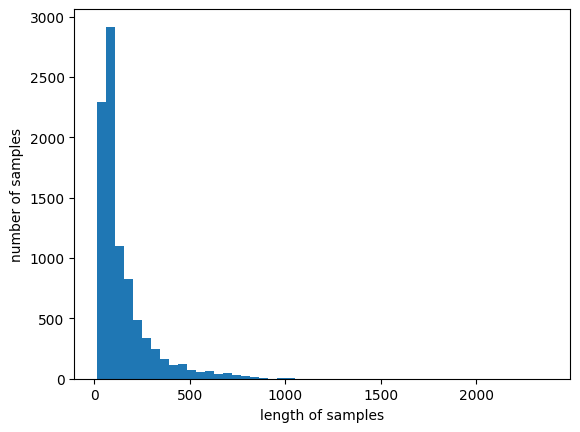

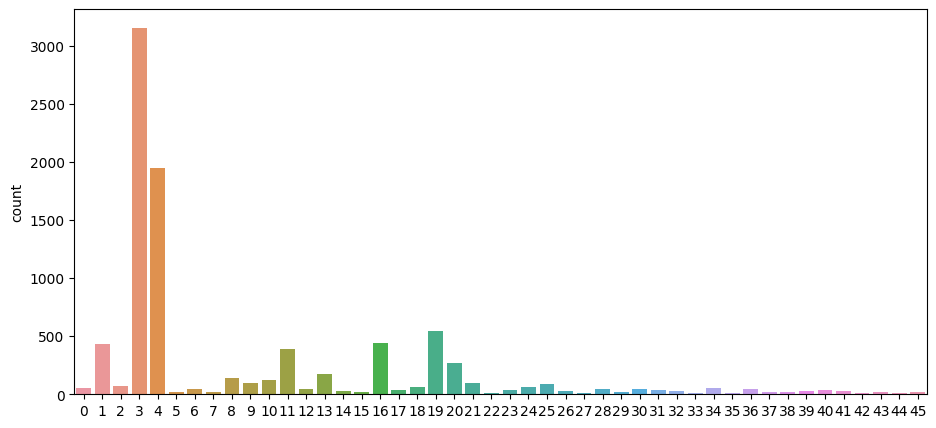

In [65]:
# 데이터 분포 확인
show_data_distribution(x_train, y_train)

In [66]:
x_train = decode_indexes_to_text(x_train, index_to_word)
x_test = decode_indexes_to_text(x_test, index_to_word)

In [67]:
# TF-IDF 전처리
tfidfv_train, tfidfv_test = preprocess_text_with_tfidf(x_train, x_test)

DTM shape: (8982, 4867)
TF-IDF Matrix shape: (8982, 4867)


In [68]:
result_02_acc, result_02_f1 = evaluate_models(tfidfv_train, y_train, tfidfv_test, y_test)
print("Accuracies:", result_02_acc)
print("F1 Scores:", result_02_f1)

in progress:  25%|██▌       | 2/8 [00:00<00:00, 11.25it/s]


Naive Bayes Classifier: Accuracy : 0.6732, F1 Score : 0.6013
Naive Bayes Classifier  model is done training

Complement Naive Bayes Classifier: Accuracy : 0.7707, F1 Score : 0.7459
Complement Naive Bayes Classifier  model is done training


in progress:  38%|███▊      | 3/8 [00:22<00:46,  9.28s/it]


Logistic Regression: Accuracy : 0.7974, F1 Score : 0.7755
Logistic Regression  model is done training


in progress:  50%|█████     | 4/8 [00:25<00:28,  7.17s/it]


Linear SVC: Accuracy : 0.8290, F1 Score : 0.8230
Linear SVC  model is done training


in progress:  62%|██████▎   | 5/8 [00:27<00:15,  5.23s/it]


Decision Tree: Accuracy : 0.6180, F1 Score : 0.5730
Decision Tree  model is done training


in progress:  75%|███████▌  | 6/8 [00:29<00:08,  4.04s/it]


Random Forest: Accuracy : 0.7012, F1 Score : 0.6770
Random Forest  model is done training


in progress:  88%|████████▊ | 7/8 [02:24<00:39, 39.94s/it]


K-Nearest Neighbors: Accuracy : 0.7649, F1 Score : 0.7533
K-Nearest Neighbors  model is done training


in progress: 100%|██████████| 8/8 [02:39<00:00, 19.91s/it]


Voting Classifier: Accuracy : 0.7983, F1 Score : 0.7767
Voting Classifier  model is done training
Accuracies: [0.6731967943009796, 0.7707034728406055, 0.7974176313446126, 0.8290293855743545, 0.6179875333926982, 0.701246660730187, 0.7649154051647373, 0.7983081032947462]
F1 Scores: [0.6012501291711391, 0.7458990404916549, 0.775490839940772, 0.8229957286229678, 0.5729970881280324, 0.6770217603524399, 0.753304500780577, 0.776747059590455]


## Case 1.3  Case 1.2  ML Models (10000 Words)

In [69]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

Train Samples No. : 8982
Train Samples No.: 2246
Train Samples Maximum length :2376
Train Samples Average length :145.5398574927633


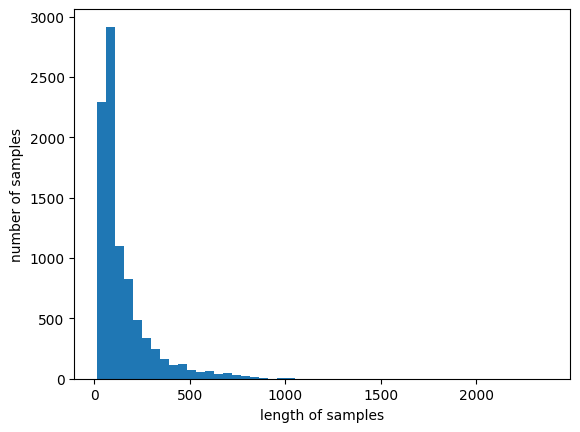

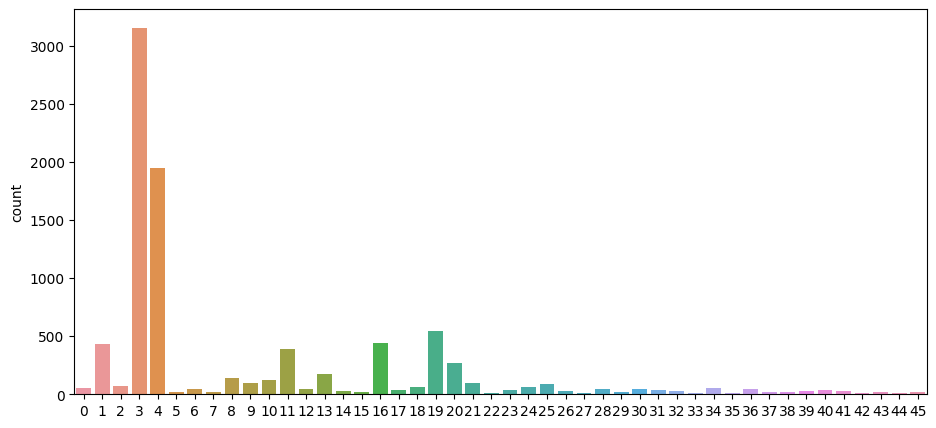

In [70]:
# 데이터 분포 확인
show_data_distribution(x_train, y_train)

In [71]:
x_train = decode_indexes_to_text(x_train, index_to_word)
x_test = decode_indexes_to_text(x_test, index_to_word)

In [72]:
# TF-IDF 전처리
tfidfv_train, tfidfv_test = preprocess_text_with_tfidf(x_train, x_test)

DTM shape: (8982, 9670)
TF-IDF Matrix shape: (8982, 9670)


In [73]:
result_03_acc, result_03_f1 = evaluate_models(tfidfv_train, y_train, tfidfv_test, y_test)
print("Accuracies:", result_03_acc)
print("F1 Scores:", result_03_f1)

in progress:  25%|██▌       | 2/8 [00:00<00:00, 16.15it/s]


Naive Bayes Classifier: Accuracy : 0.6567, F1 Score : 0.5764
Naive Bayes Classifier  model is done training

Complement Naive Bayes Classifier: Accuracy : 0.7707, F1 Score : 0.7457
Complement Naive Bayes Classifier  model is done training


in progress:  38%|███▊      | 3/8 [00:31<01:05, 13.03s/it]


Logistic Regression: Accuracy : 0.7952, F1 Score : 0.7728
Logistic Regression  model is done training


in progress:  50%|█████     | 4/8 [00:35<00:38,  9.69s/it]


Linear SVC: Accuracy : 0.8299, F1 Score : 0.8237
Linear SVC  model is done training


in progress:  62%|██████▎   | 5/8 [00:37<00:20,  6.97s/it]


Decision Tree: Accuracy : 0.6202, F1 Score : 0.5776
Decision Tree  model is done training


in progress:  75%|███████▌  | 6/8 [00:39<00:10,  5.36s/it]


Random Forest: Accuracy : 0.6741, F1 Score : 0.6429
Random Forest  model is done training


in progress:  88%|████████▊ | 7/8 [02:50<00:45, 45.86s/it]


K-Nearest Neighbors: Accuracy : 0.7689, F1 Score : 0.7603
K-Nearest Neighbors  model is done training


in progress: 100%|██████████| 8/8 [03:08<00:00, 23.57s/it]


Voting Classifier: Accuracy : 0.7979, F1 Score : 0.7761
Voting Classifier  model is done training
Accuracies: [0.6567230632235085, 0.7707034728406055, 0.7951914514692787, 0.8299198575244879, 0.6202137132680321, 0.674087266251113, 0.7689225289403384, 0.7978628673196795]
F1 Scores: [0.5764467518778252, 0.7456682614453047, 0.7727935299669956, 0.8236882254849623, 0.5776398779280149, 0.6429484177284822, 0.7602976247876144, 0.7760922070821794]


## Case 2.1  Conv 1D Layer Model without TF-IDF

In [322]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

In [323]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [324]:
print(X_train.shape, y_train.shape)

(8982,) (8982, 46)


In [325]:
X_train = pad_sequences(X_train, padding='pre')
X_test = pad_sequences(X_test, padding='pre')

In [326]:
# 데이터 분리
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [327]:
vocab_size = 10000
model = model_conv1d(vocab_size)

In [333]:
# 모델 학습 설정
model.compile(loss='categorical_crossentropy', metrics=['accuracy', f1_m])

# EarlyStopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# 모델 학습
history0 = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        batch_size=256, epochs=30, callbacks=[early_stopping])

Epoch 1/30
32/32 [==============================] - 27s 807ms/step - loss: 0.8132 - accuracy: 0.7993 - f1_m: 0.8215 - val_loss: 1.0387 - val_accuracy: 0.7553 - val_f1_m: 0.7761
Epoch 2/30
32/32 [==============================] - 25s 791ms/step - loss: 0.6881 - accuracy: 0.8246 - f1_m: 0.8408 - val_loss: 1.0974 - val_accuracy: 0.7631 - val_f1_m: 0.7823
Epoch 3/30
32/32 [==============================] - 25s 791ms/step - loss: 0.6141 - accuracy: 0.8405 - f1_m: 0.8561 - val_loss: 1.1034 - val_accuracy: 0.7575 - val_f1_m: 0.7877
Epoch 4/30
32/32 [==============================] - 25s 781ms/step - loss: 0.5569 - accuracy: 0.8519 - f1_m: 0.8664 - val_loss: 1.0480 - val_accuracy: 0.7653 - val_f1_m: 0.7817
Epoch 5/30
32/32 [==============================] - 25s 771ms/step - loss: 0.4893 - accuracy: 0.8669 - f1_m: 0.8791 - val_loss: 1.0613 - val_accuracy: 0.7720 - val_f1_m: 0.7860
Epoch 6/30
32/32 [==============================] - 25s 784ms/step - loss: 0.4429 - accuracy: 0.8786 - f1_m: 0.8838

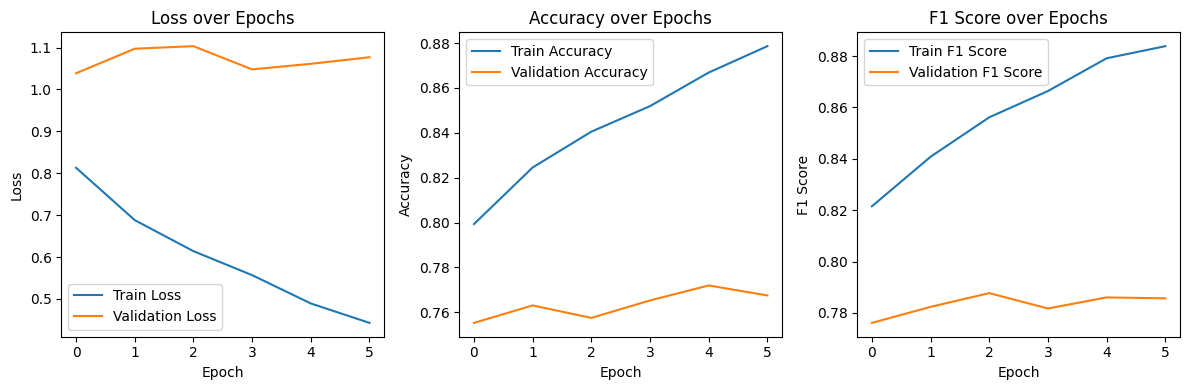

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy,Train F1 Score,Validation F1 Score
Epoch 6,0.442909,1.076955,0.878634,0.767519,0.883832,0.785671


In [348]:
visualize_model_history(history0)

In [ ]:
# 모델 평가
test_loss, test_acc, test_f1 = model.evaluate(X_test_tfidf, y_test_cat, verbose=2)

# 결과를 데이터프레임으로 출력
results = {
    'Metric': ['Accuracy', 'Loss', 'F1 Score'],
    'Value': [test_acc, test_loss, test_f1]
}

results_df = pd.DataFrame(results)
print("\nTest Results:")
display(results_df)


71/71 - 0s - loss: 0.7802 - accuracy: 0.8134 - f1_m: 0.8076 - 180ms/epoch - 3ms/step

Test Results:


,Metric,Value
0,Accuracy,0.813446
1,Loss,0.780217
2,F1 Score,0.807571


## Case 2.2. Dense Layer Model with TF-IDF
- 빈도수 상위 10000개의 단어 사용

In [354]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Load Reuters dataset
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2)

# Convert word sequences to text
X_train_text = decode_indexes_to_text(X_train, index_to_word)
X_test_text = decode_indexes_to_text(X_test, index_to_word)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text).toarray()  # Convert to dense array
X_test_tfidf = tfidf_vectorizer.transform(X_test_text).toarray()

# Convert labels to categorical
num_classes = 46
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Split data
X_train_tfidf, X_val_tfidf, y_train_cat, y_val_cat = train_test_split(X_train_tfidf, y_train_cat, test_size=0.1, random_state=42)


vocab_size = 10000
model = model_dense(X_train_tfidf.shape[1])
# Compile the model
model.compile(loss='categorical_crossentropy',  optimizer='adam', metrics=['accuracy', f1_m])

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

# Train the model
history = model.fit(X_train_tfidf, y_train_cat, validation_data=(X_val_tfidf, y_val_cat),
                    batch_size=256, epochs=30, callbacks=[early_stopping])


Epoch 1/30
32/32 [==============================] - 2s 22ms/step - loss: 3.1897 - accuracy: 0.5045 - f1_m: 0.0000e+00 - val_loss: 2.2650 - val_accuracy: 0.5806 - val_f1_m: 0.0000e+00
Epoch 2/30
32/32 [==============================] - 0s 11ms/step - loss: 1.7497 - accuracy: 0.6241 - f1_m: 0.4231 - val_loss: 1.4693 - val_accuracy: 0.6774 - val_f1_m: 0.6312
Epoch 3/30
32/32 [==============================] - 0s 11ms/step - loss: 1.2196 - accuracy: 0.7320 - f1_m: 0.6983 - val_loss: 1.1832 - val_accuracy: 0.7430 - val_f1_m: 0.7172
Epoch 4/30
32/32 [==============================] - 0s 12ms/step - loss: 0.9513 - accuracy: 0.7952 - f1_m: 0.7677 - val_loss: 1.0287 - val_accuracy: 0.7798 - val_f1_m: 0.7602
Epoch 5/30
32/32 [==============================] - 0s 10ms/step - loss: 0.7669 - accuracy: 0.8379 - f1_m: 0.8124 - val_loss: 0.9254 - val_accuracy: 0.7976 - val_f1_m: 0.7747
Epoch 6/30
32/32 [==============================] - 0s 10ms/step - loss: 0.6246 - accuracy: 0.8706 - f1_m: 0.8409 - v

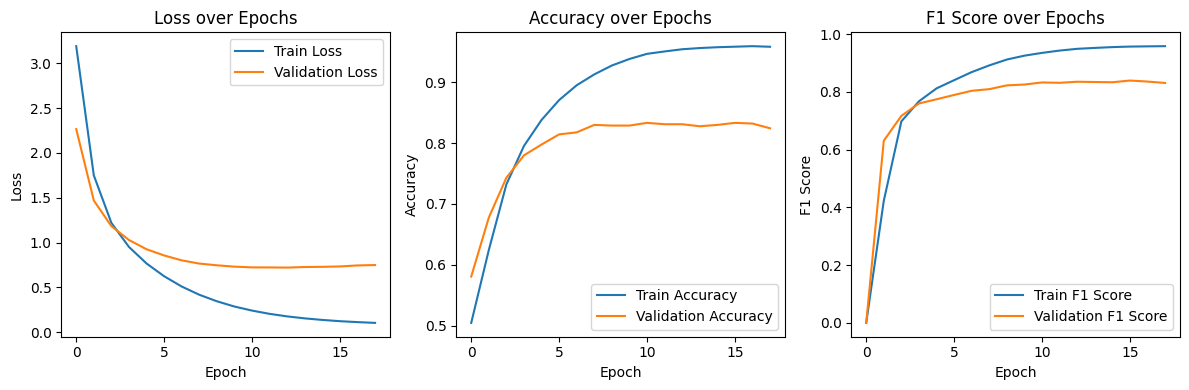

,Train Loss,Validation Loss,Train Accuracy,Validation Accuracy,Train F1 Score,Validation F1 Score
Epoch 18,0.104395,0.749302,0.958184,0.824249,0.958714,0.831299


In [355]:
visualize_model_history(history)

In [358]:
# 모델 평가
test_loss, test_acc, test_f1 = model.evaluate(X_test_tfidf, y_test_cat, verbose=2)

# 결과를 데이터프레임으로 출력
results = {
    'Metric': ['Accuracy', 'Loss', 'F1 Score'],
    'Value': [test_acc, test_loss, test_f1]
}

results_df = pd.DataFrame(results)
print("\nTest Results:")
display(results_df)


71/71 - 0s - loss: 0.7802 - accuracy: 0.8134 - f1_m: 0.8076 - 180ms/epoch - 3ms/step

Test Results:


,Metric,Value
0,Accuracy,0.813446
1,Loss,0.780217
2,F1 Score,0.807571


## Final Report

Model Performance for All words
               Model  Accuracy  F1 Score(weighted)
       MultinomialNB  0.656723            0.576447
        ComplementNB  0.770703            0.745668
 Logistic Regression  0.795191            0.772794
           LinearSVC  0.829920            0.823688
       Decision Tree  0.620214            0.577640
       Random Forest  0.674087            0.642948
KNeighborsClassifier  0.768923            0.760298
              Voting  0.797863            0.776092


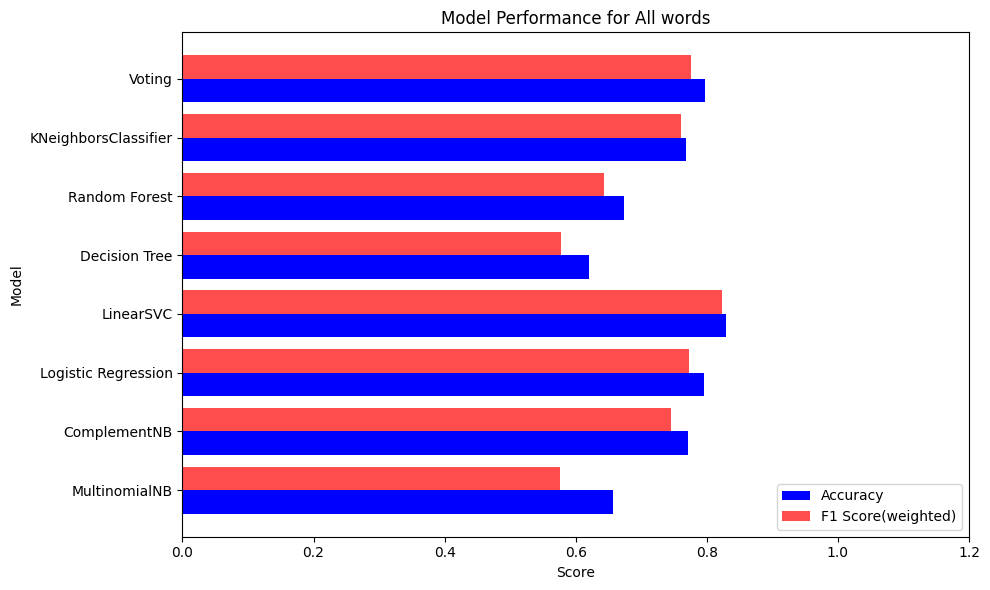

In [77]:
visualize_model_scores(classifier_list, result_01_acc, result_01_f1, "Model Performance for All words")

Model Performance for 5000 words
               Model  Accuracy  F1 Score(weighted)
       MultinomialNB  0.673197            0.601250
        ComplementNB  0.770703            0.745899
 Logistic Regression  0.797418            0.775491
           LinearSVC  0.829029            0.822996
       Decision Tree  0.617988            0.572997
       Random Forest  0.701247            0.677022
KNeighborsClassifier  0.764915            0.753305
              Voting  0.798308            0.776747


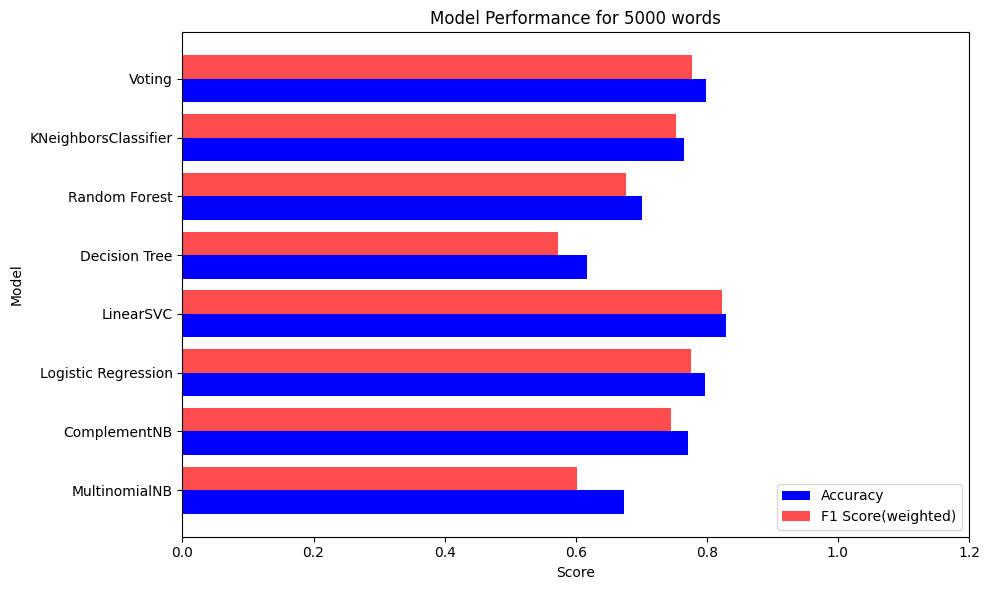

In [78]:
visualize_model_scores(classifier_list, result_02_acc, result_02_f1, "Model Performance for 5000 words")

Model Performance for 10000 words
               Model  Accuracy  F1 Score(weighted)
       MultinomialNB  0.656723            0.576447
        ComplementNB  0.770703            0.745668
 Logistic Regression  0.795191            0.772794
           LinearSVC  0.829920            0.823688
       Decision Tree  0.620214            0.577640
       Random Forest  0.674087            0.642948
KNeighborsClassifier  0.768923            0.760298
              Voting  0.797863            0.776092


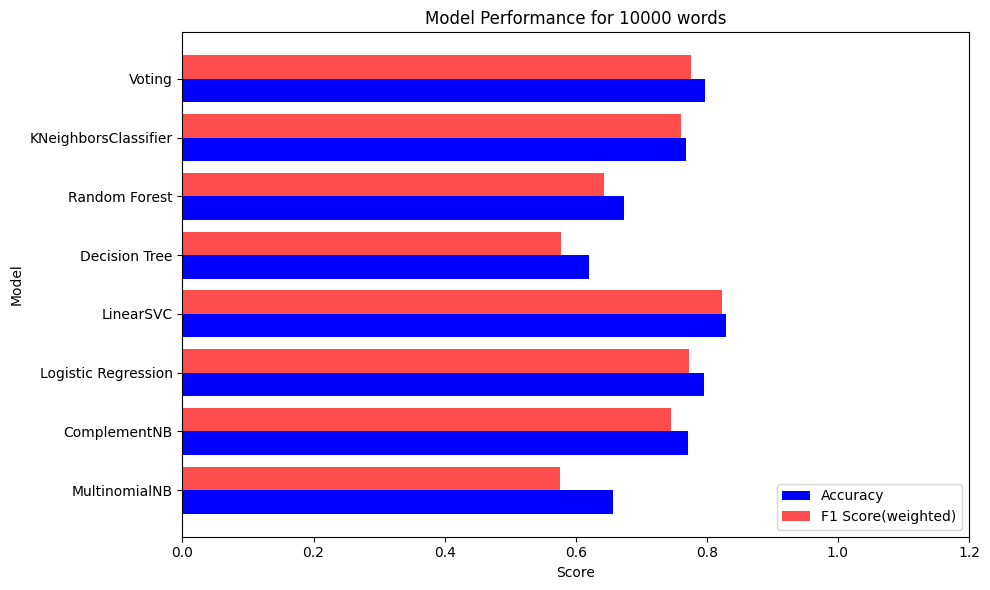

In [79]:
visualize_model_scores(classifier_list, result_03_acc, result_03_f1, "Model Performance for 10000 words")

In [80]:
best_classifier_name = find_best_classifier(classifier_list, result_01_acc, result_01_f1)
print("All words Best Classifier :", best_classifier_name)


All words Best Classifier : LinearSVC (Acc: 0.8299, F1: 0.8237)


In [81]:
best_classifier_name = find_best_classifier(classifier_list, result_02_acc, result_02_f1)
print("5000 words Best Classifier :", best_classifier_name)


5000 words Best Classifier : LinearSVC (Acc: 0.8290, F1: 0.8230)


In [82]:
best_classifier_name = find_best_classifier(classifier_list, result_03_acc, result_03_f1)
print("10000 words Best Classifier :", best_classifier_name)

10000 words Best Classifier : LinearSVC (Acc: 0.8299, F1: 0.8237)


In [361]:
print("Results of Conv1d Layer Model without TF-IDF")
display(results_df0)
print("Results of Dense Layer Model with TF-IDF")
display(results_df)

Results of Conv1d Layer Model without TF-IDF


,Metric,Value
0,Accuracy,0.767587
1,Loss,1.080302
2,F1 Score,0.777144


Results of Dense Layer Model with TF-IDF


,Metric,Value
0,Accuracy,0.813446
1,Loss,0.780217
2,F1 Score,0.807571


- ML 모델에서 모든 케이스에 있어서 SVM 모델의 성능이 가장 높았습니다.
- SVM 모델이 벡터화에 최적화된 모델이어서, 이런 결과가 나온 것이라고 추측합니다.
- 또한 Reuters 데이터셋은 클래스 간의 불균형이 심해서, SVM 이 가장 좋은 성능을 보였다고
- 단어의 사용 갯수에 따른 성능 차이는 미미했습니다.
- 이 데이터셋에서는 결국 어떤 모델을 선택하느냐가 더 중요한 요인이었던 것으로 보입니다.

- 또한, TF-IDF 를 적용하지 않은, Conv1D DNN 모델과의 성능을 비교했을 때에, TF-IDF 를 적용하지 않은 케이스는 SVM 모델보다 성능이 낮았지만, TF-IDF 를 적용한 Dense Layer 로만 구성된 DNN 모델은 SVM 모델 결과와 유사한 성능을 보였습니다.  

- cf.) Dense Layer 를 위에 구조보다 복잡하게 구현한다고 해서 성능이 개선되지는 않았습니다.

- cf.) 수학적으로 아직 완벽하게 이해하진 못했지만, Single Label Multiclass Classification 문항에서는, F1 Score Micro 가 결국 Accuracy 랑 같은 값을 갖게 됩니다. 따라서, F1 Score Weigthed 로 정정해서 다시 측정하였습니다.

From GPT

클래스 간의 불균형이 심한 경우에 SVM이 더 나은 성능을 보일 수 있는 이유는 SVM의 작동 원리와 불균형 데이터셋에 대한 특성 때문입니다. 이해를 돕기 위해 좀 더 자세히 설명해보겠습니다:

1. **Margin 최대화**: SVM은 경계(margin)를 최대화하는 방향으로 데이터를 분리하려고 시도합니다. 따라서 클래스 간의 간격을 최대로 유지하며 데이터를 분류하려는 경향이 있습니다. 클래스 간의 불균형이 심한 경우, 더 많은 예측을 더 많은 데이터에 할당하는 것이 효과적일 수 있습니다. SVM은 이러한 클래스 간의 간격을 늘리는 방향으로 학습하므로 불균형 데이터셋에서도 강건한 성능을 발휘할 수 있습니다.

2. **Support Vector의 역할**: SVM의 핵심 개념 중 하나는 Support Vector입니다. 이는 결정 경계에 가까운 데이터 포인트들을 말합니다. 클래스 간의 불균형이 심할 경우, 소수 클래스에 속하는 데이터 포인트가 결정 경계에 더 가까워질 수 있습니다. 이렇게 결정 경계에 가까운 Support Vector들은 더 중요한 데이터로 간주되며, SVM은 이들을 더 잘 분류하도록 학습하려는 경향이 있습니다.

3. **Weighted Loss**: 클래스 간의 불균형을 처리하기 위해 SVM은 소수 클래스에 높은 가중치를 부여하는 방식으로 학습할 수 있습니다. 이는 소수 클래스에 대한 오분류 비용을 더 높이는 효과를 가질 수 있습니다.

반면에, Dense Layer 모델은 데이터로부터 자동으로 특징을 학습하고 복잡한 관계를 모델링하려는 경향이 있습니다. 따라서 클래스 간의 불균형이 심한 경우, 미세한 클래스의 데이터가 상대적으로 덜 주목받을 수 있고, 오버피팅 문제가 발생할 수 있습니다. 이러한 문제를 해결하기 위해서는 클래스 간의 균형을 맞추는 방법이나 소수 클래스에 더 많은 비중을 부여하는 방법 등의 추가적인 조치가 필요할 수 있습니다.

결국, 클래스 간의 불균형 정도, 데이터셋의 크기, 모델의 특성 등에 따라 SVM과 Dense Layer 모델의 성능이 달라질 수 있습니다. 이러한 이유로 클래스 간의 불균형이 심한 경우, SVM이 더 나은 성능을 보일 수 있습니다.